### Importing and preprocessing the data

In [234]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score
from numpy import clip, column_stack, argmax
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('wbco.csv', header=None)
indexes = ['LThick', 'UCellSize', 'UCellShape', 'MAdhesion', 'SECS', 'BlandC', 'NormNuc', 'Mitoses', 'Unknown', 'Target']
data.columns = indexes

indexes = indexes[:-1]

In [235]:
data.head()

,LThick,UCellSize,UCellShape,MAdhesion,SECS,BlandC,NormNuc,Mitoses,Unknown,Target
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


In [236]:
data.describe()

,LThick,UCellSize,UCellShape,MAdhesion,SECS,NormNuc,Mitoses,Unknown,Target
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,0.344778
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.475636
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [237]:
data.isnull().sum()

LThick        0
UCellSize     0
UCellShape    0
MAdhesion     0
SECS          0
BlandC        0
NormNuc       0
Mitoses       0
Unknown       0
Target        0
dtype: int64

In [238]:
data.dtypes == int

LThick         True
UCellSize      True
UCellShape     True
MAdhesion      True
SECS           True
BlandC        False
NormNuc        True
Mitoses        True
Unknown        True
Target         True
dtype: bool

A variável 'BlandC' está atualmente definida como string pois possui algumas entradas com '?'. Como resolver este problema? O número de entradas sem valor é significativo?

In [239]:
na_perc = (data.BlandC[data.BlandC == '?']).count() / data.BlandC.count() * 100
print(str(na_perc) + '% percent of entries are null.')

2.28898426323319% percent of entries are null.


Selected aproach: fill missing values with the column's average.

In [240]:
avg = data.BlandC[data.BlandC != '?'].astype(float).mean()
data.loc[data.BlandC == '?', 'BlandC'] = avg
data.BlandC = data.BlandC.astype(int)

#### Creating a train-test split

In [241]:
data_x = data.drop('Target', axis = 1)
data_y = data.Target

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2, random_state=21)

In [242]:
# scaling the data

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

#### Feature Selection

<Axes: >

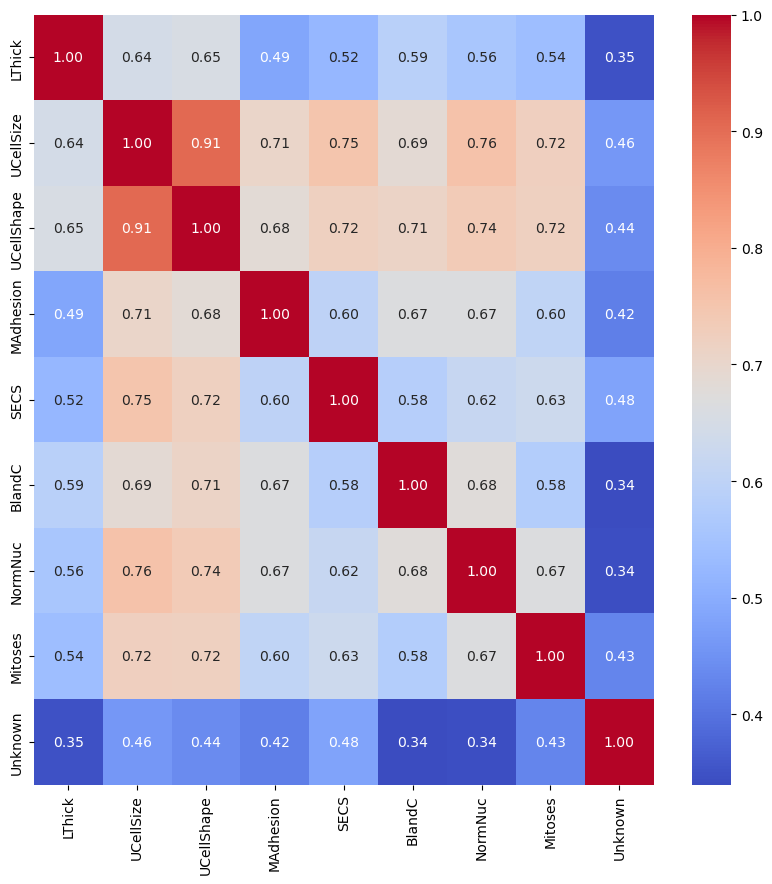

In [243]:
correlation_matrix = data[indexes].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

In [244]:
# Sice the var UCellSize has got a relatively high correlation to some of the  variables, we are dropping it 
data = data.drop('UCellSize', axis = 1)

Text(0, 0.5, 'Component size')

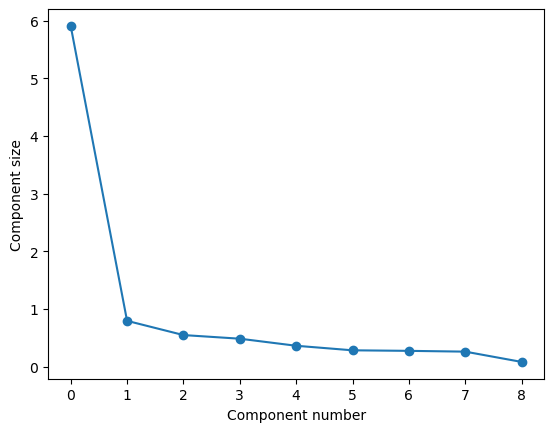

In [245]:
# applying PCA Analysis
# generate scree plot to determine the optimal value for the n_components parameter 

pca = PCA()
x_train = pca.fit_transform(x_train)
explained_variance = pca.explained_variance_ratio_
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Component number")
plt.ylabel("Component size")

In [246]:
pca = PCA(n_components = 4)
x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)

### Building the model

Neural network model

In [247]:
def trainMLP(HLS):
    regr = MLPClassifier(hidden_layer_sizes=HLS,random_state=42, max_iter=500)
    regr.fit(x_train, y_train)

    # %% Get model predictions
    y_pred = regr.predict(x_test)

    # %% Compute classification metrics
    print('')
    print('Architecture: {list}'.format(list = HLS))
    acc_score = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.3f}".format(acc_score))
    rec_score = recall_score(y_test, y_pred)
    print("Recall: {:.3f}".format(rec_score))
    prec_score = precision_score(y_test, y_pred)
    print("Precision Score: {:.3f}".format(prec_score))
    F1_score = f1_score(y_test, y_pred)
    print("F1-Score: {:.3f}".format(F1_score))
    kappa = cohen_kappa_score(y_test, y_pred)
    print("Kappa Score: {:.3f}".format(kappa))


In [249]:
Architectures = [[5],[10], [5, 5], [5, 10],[10, 10]]

for i in Architectures: trainMLP(i)


Architecture: [5]
Accuracy: 0.964
Recall: 0.943
Precision Score: 0.962
F1-Score: 0.952
Kappa Score: 0.924

Architecture: [10]
Accuracy: 0.950
Recall: 0.906
Precision Score: 0.960
F1-Score: 0.932
Kappa Score: 0.893

Architecture: [5, 5]
Accuracy: 0.957
Recall: 0.925
Precision Score: 0.961
F1-Score: 0.942
Kappa Score: 0.908

Architecture: [5, 10]
Accuracy: 0.964
Recall: 0.943
Precision Score: 0.962
F1-Score: 0.952
Kappa Score: 0.924

Architecture: [10, 10]
Accuracy: 0.950
Recall: 0.906
Precision Score: 0.960
F1-Score: 0.932
Kappa Score: 0.893


Não esquecer que para dados medicos, a metrica mais importante é a ...(confirmar)